# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import load_dataset as load
import subphase_calc_functions as subphase_calc
import access_functions as af

In [2]:
import access_general_functions as access_general

import accuracy_plots as acc_plot

import access_correlation_functions as access_corr

In [3]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables()

4159 4159
4159 4159


# Calculation

<b> Splitting AWAP and ACCESS

In [4]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [5]:
subphase_calc = reload(subphase_calc)
# Split access into the subphases: enhanced, suppressed, transition and inactive.
access_split = af.access_rmm_split(access, rmm_access)

1 2 3 4 5 6 7 8 9 10 11 

<b> RMM Count 

In [6]:
access_general = reload(access_general)
rmm_count_obs  = access_general.count_in_rmm_subphase_year_month_resample(rmm_obs)

<b> AWAP anomalies

In [7]:
# Count
access_corr = reload(access_corr)
count_anom = access_corr.count_month_year_anomalies(awap_split, awap, rmm_count_obs)

# Sum
access_corr = reload(access_corr)
sum_anom = access_corr.sum_month_year_anomalies(awap_split, awap, rmm_count_obs)

# Mean
access_corr = reload(access_corr)
mean_anom = access_corr.mean_month_year_anomalies(awap_split, awap, rmm_count_obs)

<b> ACCESS anomlies

In [8]:
# Count
access_general = reload(access_general)
access_corr = reload(access_corr)
count_anom_ens, count_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.count_month_year_anomalies)

# Sum
access_general = reload(access_general)
access_corr = reload(access_corr)
sum_anom_ens, sum_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.sum_month_year_anomalies)

# Mean
access_general = reload(access_general)
access_corr = reload(access_corr)
mean_anom_ens, mean_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.mean_month_year_anomalies)

# Accuarcy Calculation

## Functions

In [9]:
# The accuary for each month
def accuary_month(obs,mod):
    # Getting just th emodel where awap has rain and vice-verse
    mod.where(np.isfinite(obs.precip.values))
    obs.where(np.isfinite(mod.precip.values))

    
    
    # The max score is the amount of times values actually appear
    max_score = obs.count(dim = 'year')

    # The times the model is correct with the sign of the anomalies:
        # Both model and observations are reduced anomaly
    correct_pos = obs.where(np.logical_and(obs.precip > 1,mod.precip > 1)) 
        # Both are positive anomalies
    correct_neg = obs.where(np.logical_and(obs.precip < 1,mod.precip < 1)) 
    
    # The total score
    score = correct_neg.count(dim = 'year') + correct_pos.count(dim = 'year')
    
    # The percent that was correct
    percent = score * 100 /max_score

    return percent

In [10]:
# The accuracy for the early and late wet season
def accuary_2div(obs_tot,mod_tot):
    month_groups = [[10,11,12],[1,2,3]]
    month_stor = []
    for months in month_groups:
        obs = obs_tot.sel(month = months)
        mod = mod_tot.sel(month = months)

        # Getting just th emodel where awap has rain and vice-verse
        mod = mod.where(np.isfinite(obs.precip.values))
        obs = obs.where(np.isfinite(mod.precip.values))

        max_score = obs.count(dim = 'year').sum(dim = 'month')
        # Both model and observations are reduced anomaly
        correct_neg = obs.where(np.logical_and(obs.precip < 1,mod.precip < 1))
        # Both are positive anomalies
        correct_pos = obs.where(np.logical_and(obs.precip > 1,mod.precip > 1))  

        #Adding together the scores
        score = correct_neg.count(dim = 'year') + correct_pos.count(dim = 'year')
        # Summing acorss month, to get the values for early and late wet season
        score = score.sum(dim = 'month')

        # The percent of scores that are correct
        percent = score * 100 /max_score
        month_stor.append(percent)
        
    # Combing into the one xarray file
    accuracy_count_2div = xr.concat(month_stor, pd.Index(['early','late'], name = 'month'))
    
    
    return accuracy_count_2div

## Output

In [11]:
# Count
accuracy_count_2div = accuary_2div(count_anom,count_anom_ens_med)

accuracy_count_month = accuary_month(count_anom,count_anom_ens_med)

In [12]:
# Sum
accuracy_sum_2div = accuary_2div(sum_anom,sum_anom_ens_med)

accuracy_sum_month = accuary_month(sum_anom,sum_anom_ens_med)

In [13]:
# Mean
accuracy_mean_2div = accuary_2div(mean_anom,mean_anom_ens_med)

accuracy_mean_month = accuary_month(mean_anom,mean_anom_ens_med)

# Plots

In [35]:
savedir = '../images/access/accuracy/'

## 2div

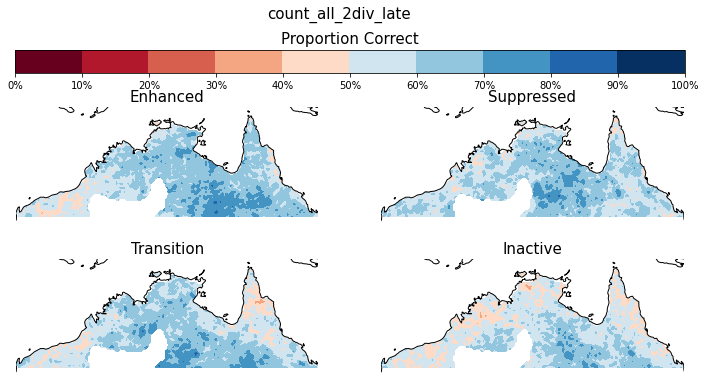

In [19]:
acc_plot = reload(acc_plot)
month = 'late'
savetitle = f'count_{q}_2div_{month}'
acc_plot.accuracy_plot(accuracy_count_2div.sel(month = month), vmin = 0, vmax = 100, 
                       savetitle = savetitle)#, savedir = savedir)

# All Months

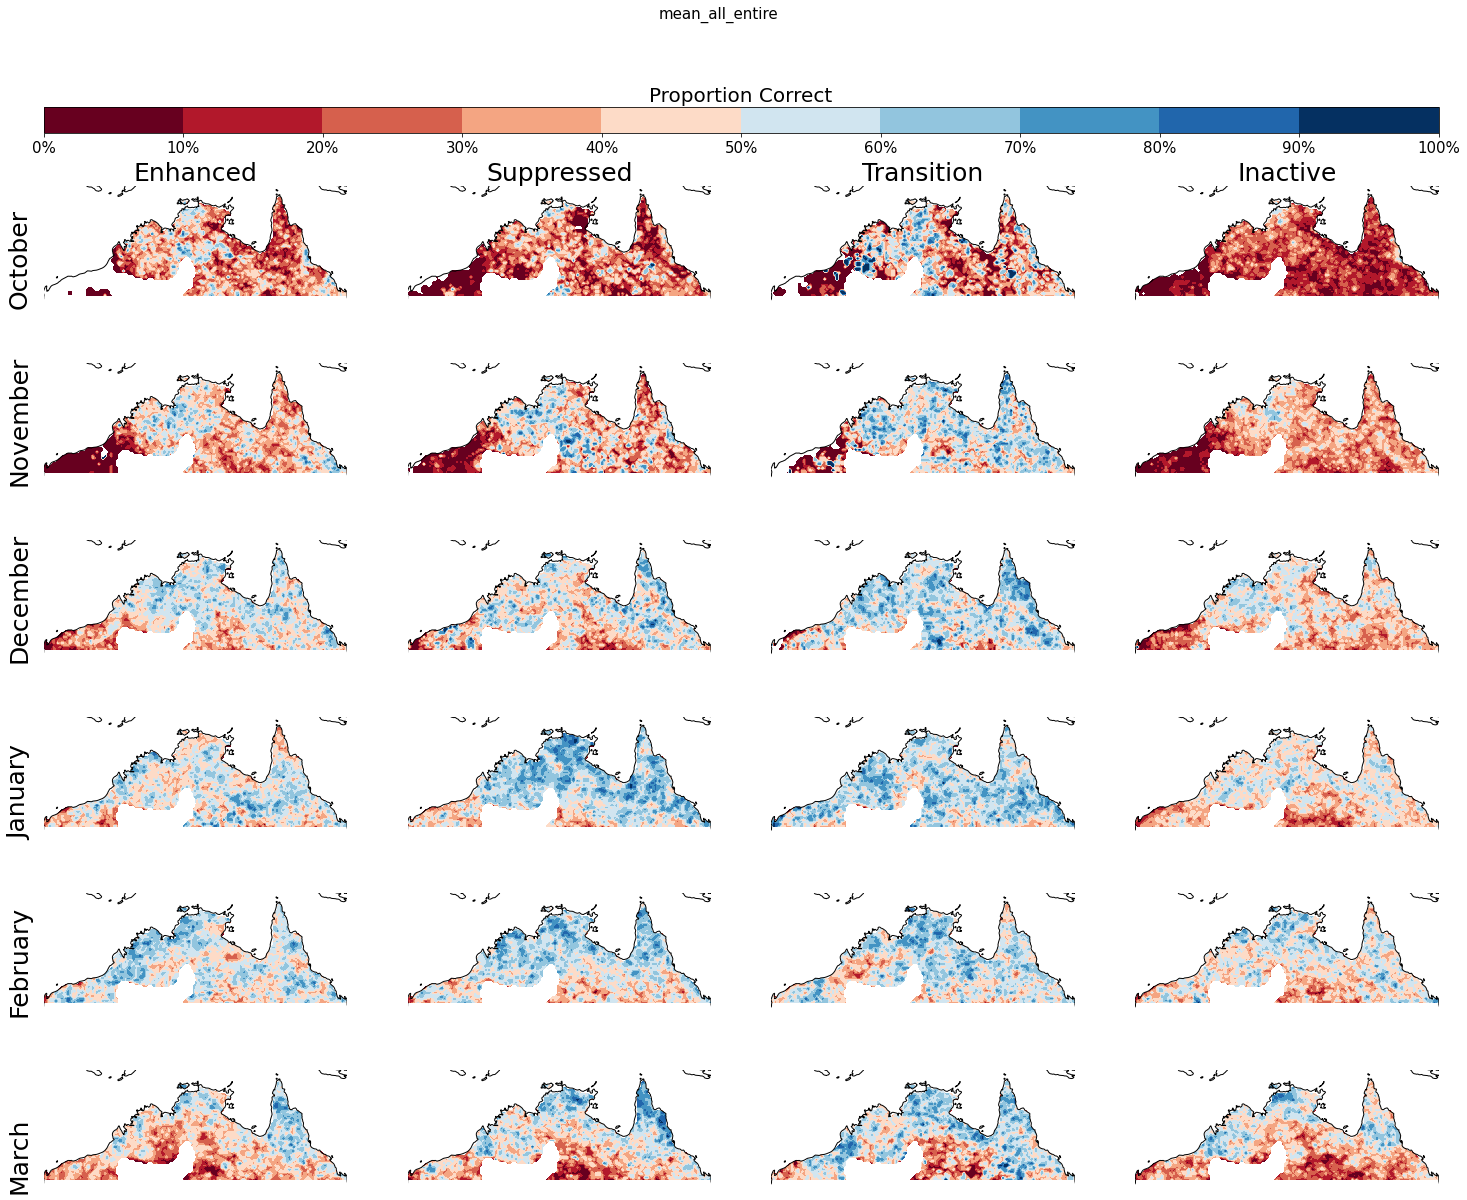

In [38]:
acc_plot = reload(acc_plot)
savetitle = f'mean_{q}_entire'
acc_plot.accuracy_plot_all_months(accuracy_mean_month, savetitle = savetitle, savedir = savedir)

# Entire Phase

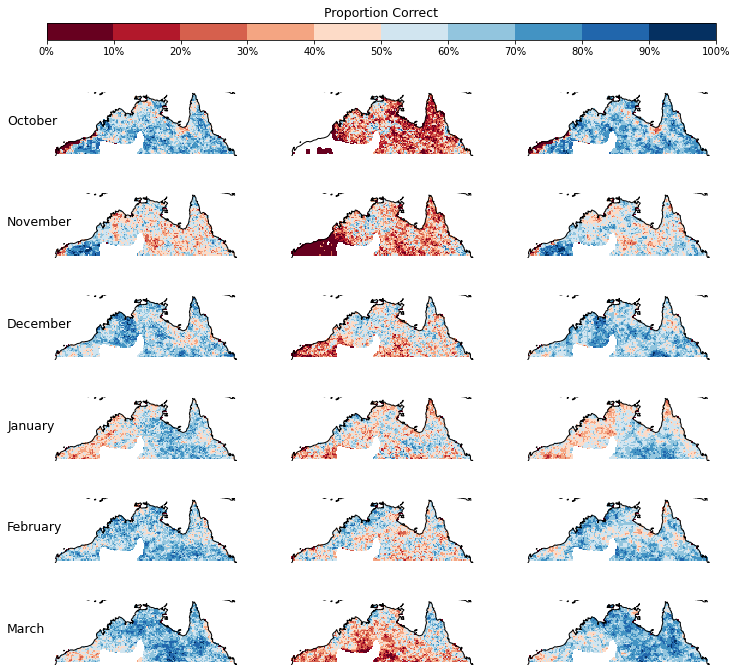

In [15]:
acc_plot = reload(acc_plot)
acc_plot.accuracy_plot_single_phase_multi_indinice([accuracy_count_month ,accuracy_mean_month ,accuracy_sum_month ],
                                          titles = ['','',''])

# Single Month

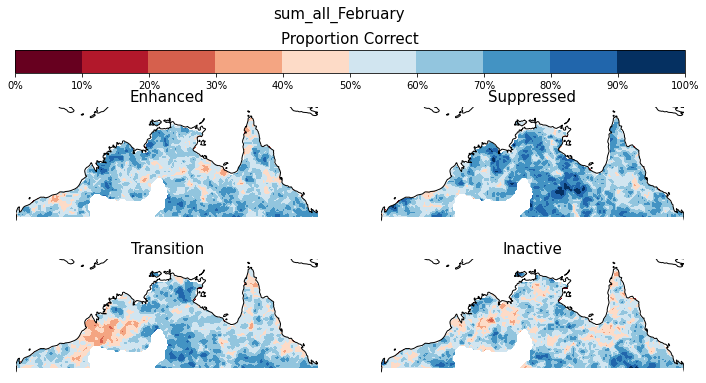

In [79]:
acc_plot = reload(acc_plot)
month = 2
savetitle = f'sum_{q}_{calendar.month_name[month]}'

acc_plot.accuracy_plot(accuracy_sum_month.sel(month = month), vmin = 0, vmax = 100, 
                       savetitle = savetitle)
# , savedir = savedir)

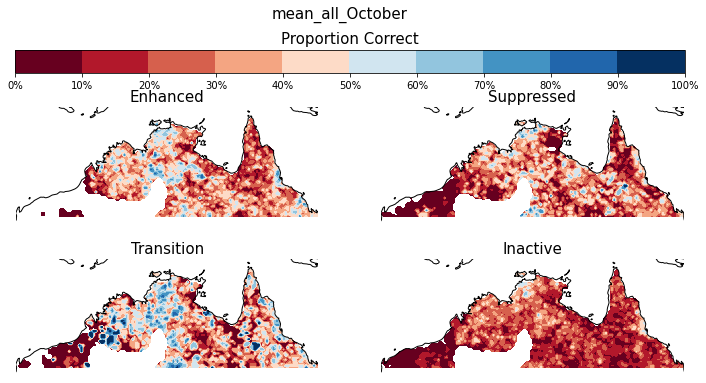

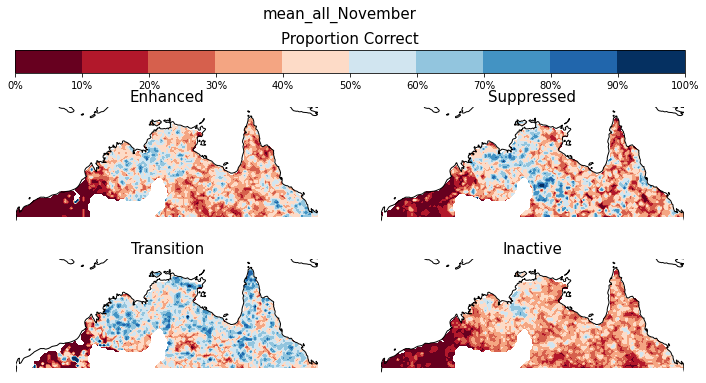

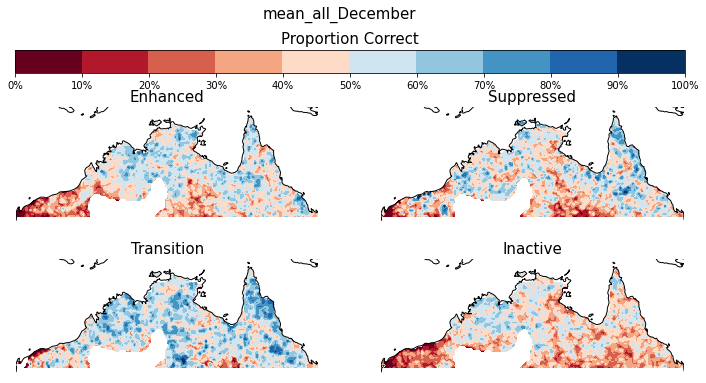

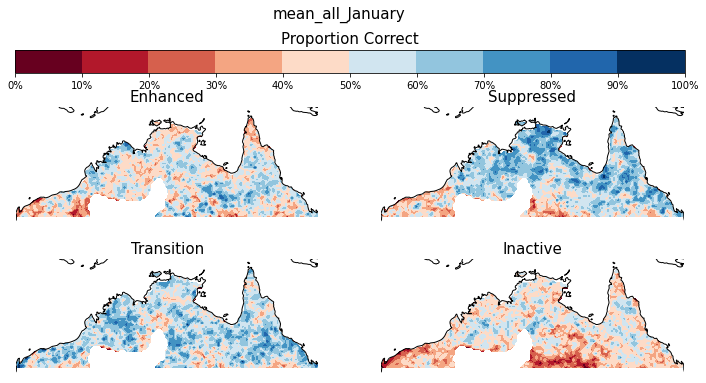

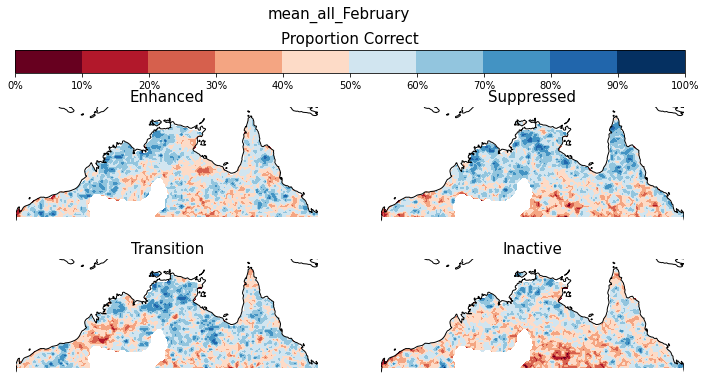

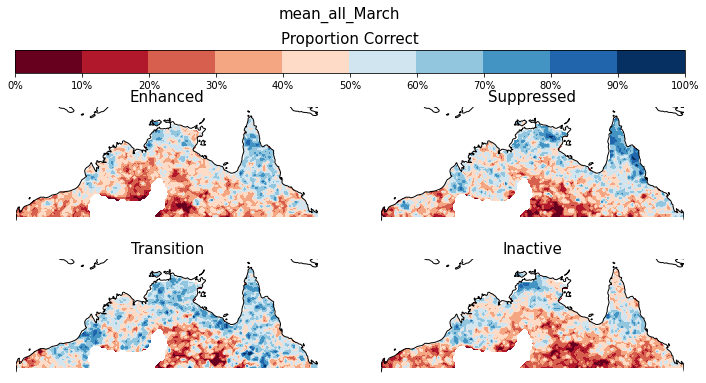

In [90]:
for month in [10,11,12,1,2,3]:
    
    savetitle = f'mean_{q}_{calendar.month_name[month]}'

    acc_plot.accuracy_plot(accuracy_mean_month.sel(month = month), vmin = 0, vmax = 100, 
                       savetitle = savetitle, savedir = savedir)